In [1]:
from trainers.trainer import Trainer
from nn.dataset import BirdDataset
from nn.cnn import CNN
from cfgs.replicate_config import config
from utils.spec_utils import SpecFeatureExtractor, NormalizeMelSpec
import torchaudio

from albumentations import HorizontalFlip,  Compose, Normalize, CoarseDropout
from albumentations.pytorch import ToTensorV2
import torch

In [2]:
trainer = Trainer()

In [3]:
df, config = trainer.prepare_dataframe_config(config)

In [4]:
train_transforms = Compose([
            HorizontalFlip(p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)

In [10]:
trn_dataset = BirdDataset(df=df, config=config["data_config"], wave_transforms=[], image_transform=train_transforms, is_train=True)
train_loader = torch.utils.data.DataLoader(trn_dataset, shuffle=False,  **config["train_loader_config"])

In [11]:
for batch in train_loader:
    break

In [12]:
# val = trn_dataset.__getitem__(0)
# val["spec"].shape
# val["spec"] = val["spec"].unsqueeze(0)


In [16]:
config["data_config"]["num_classes"] = 182
model = CNN(config)
model.train()
print (" ")

feature dims: [1536, 2304]
 


In [17]:
input = model.get_features(batch)

In [18]:
input

{'spec': tensor([[-0.9838, -0.8732, -0.9890,  ..., -0.1568, -0.8588, -0.1441],
         [-0.1778,  2.8398,  0.1644,  ...,  1.8373, -0.5022, -0.6493],
         [-0.8356, -1.2221,  1.2723,  ..., -0.9296, -1.5938,  0.8625],
         ...,
         [-0.3591, -0.5462,  0.6500,  ..., -0.3612,  0.4617,  1.9675],
         [-0.2834,  2.0798, -1.3034,  ...,  1.2763, -0.4263, -0.5939],
         [ 1.8182, -0.4236, -1.3478,  ..., -0.8944, -2.2619, -0.5498]],
        grad_fn=<NativeBatchNormBackward0>),
 'loss_target': tensor([[9.0055e-01, 5.4945e-04, 5.4945e-04,  ..., 5.4945e-04, 5.4945e-04,
          5.4945e-04],
         [9.0055e-01, 5.4945e-04, 5.4945e-04,  ..., 5.4945e-04, 5.4945e-04,
          5.4945e-04],
         [9.0055e-01, 5.4945e-04, 5.4945e-04,  ..., 5.4945e-04, 5.4945e-04,
          5.4945e-04],
         ...,
         [9.0055e-01, 5.4945e-04, 5.4945e-04,  ..., 5.4945e-04, 5.4945e-04,
          5.4945e-04],
         [9.0055e-01, 5.4945e-04, 5.4945e-04,  ..., 5.4945e-04, 5.4945e-04,
     

In [7]:
from albumentations import HorizontalFlip,  Compose, Normalize, CoarseDropout
from albumentations.pytorch import ToTensorV2

In [25]:
config["mel_spec_paramms"].pop("top_db")

80

In [31]:
logmelspec_extractor = SpecFeatureExtractor(config["mel_spec_paramms"], config["exportable"],
                                                         80)

STFT kernels created, time used = 0.0425 seconds


In [32]:
spec = logmelspec_extractor(val["wave"][None, ])

In [33]:
spec.shape

torch.Size([1, 1, 128, 313])

In [15]:
spec = (spec[0, ] * 255.0)
spec[spec > 255] = 255
spec = spec.expand(3, -1, -1)
spec = spec.numpy().transpose(1, 2, 0)

NameError: name 'spec' is not defined

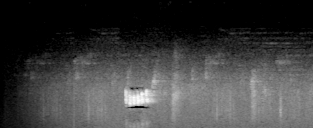

In [35]:
Image.fromarray(spec.astype('uint8'))

In [23]:
import numpy as np
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [79]:
 mel_spec_params = config["mel_spec_paramms"]
 mel_spec_extractor = torchaudio.transforms.MelSpectrogram(sample_rate=32000, hop_length=mel_spec_params["hop_length"], n_mels=mel_spec_params["n_mels"], 
                    f_min=mel_spec_params["f_min"], f_max=mel_spec_params["f_max"], n_fft=mel_spec_params["n_fft"], 
                                      center=True, pad_mode='constant',norm='slaney',onesided=True,mel_scale='slaney')
 db_transform = torchaudio.transforms.AmplitudeToDB(stype='power',top_db=mel_spec_params["top_db"])
 spec_tr = db_transform(mel_spec_extractor(val["wave"]))
 # spec_tr = (spec_tr + 80) / 80
 spec_tr = norm(spec_tr)
 

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [71]:
spec = spec_tr * 255.0
spec[spec > 255] = 255
spec = spec.unsqueeze(2).expand(-1, -1, 3)
spec = spec.numpy()
spec.shape


(128, 313, 3)

In [72]:
from PIL import Image

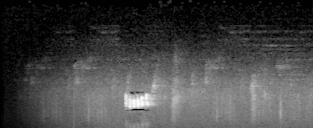

In [73]:
Image.fromarray(spec.astype("uint8"))